In [1]:
import sys
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point
from utils.dbutils import get_drought_codes_table
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from pathlib import Path
from sqlalchemy import create_engine, text
from rasterio.features import geometry_mask
import rasterio
import numpy as np

sys.path.append(str(Path.home() / "Documents" / "github"))
from pydroinformatics.pydroinformatics.src import rasterutils

First we load all the 'drought codes' data, which includes data on stations, freeze-up (freeze), melt (snowfree), and drought code metadata.

In [2]:
import geopandas as gpd


gdf = gpd.read_file(r"C:\Users\esniede\Downloads\Weather_Stations.shp.zip")
gdf.explore()

In [3]:
gdf.sort_values(by="STATN_CODE", inplace=True)
gdf

,NAME,STATN_CODE,LAT_DD,LONG_DD,ELEV_M,OWNER,geometry
53,Antimony Creek,ANT,64.014710,-138.615440,547.0,Yukon Wildland Fire Management,POINT (201792.902 1073013.172)
31,Barlow,BAR,63.774056,-137.626786,761.0,Yukon Wildland Fire Management,POINT (247717.478 1041962.64)
32,Beaver Creek Town,BCT,62.379650,-140.878217,662.0,Yukon Wildland Fire Management,POINT (67970.545 904768.776)
45,Braeburn,BR,61.481453,-135.779817,728.0,Yukon Wildland Fire Management,POINT (325279.034 780581.721)
36,Carmacks,CA,62.084756,-136.291047,600.0,Yukon Wildland Fire Management,POINT (302093.425 849219.842)
33,Carcross,CC,60.179235,-134.696382,660.0,Yukon Wildland Fire Management,POINT (377944.926 633192.161)
34,Champagne,CH,60.811600,-136.446150,710.0,Yukon Wildland Fire Management,POINT (285183.815 708142.011)
16,Dawson City Airport,CYDA,64.040000,-139.126109,370.0,Environment Canada,POINT (177272.887 1078322.802)
12,Burwash Airport,CYDB,61.370000,-139.050000,807.0,Environment Canada,POINT (150255.667 781726.362)
23,Fort Liard Airport,CYJF,60.230000,-123.467000,216.0,Environment Canada,POINT (999574.225 672373.645)


In [4]:
# Set the working directory to the script's location
stations = get_drought_codes_table('table_stations', db_path='.data/drought_codes.sqlite')
# Create a GeoDataFrame from the stations DataFrame
stations['geometry'] = stations.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
stations_gdf = gpd.GeoDataFrame(stations, geometry='geometry')

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
stations_gdf.set_crs(epsg=4326, inplace=True)

# convert freeze and thaw dataframes to geoDataFrames with datetime stamps
freeze = get_drought_codes_table('freeze_up', db_path='.data/drought_codes.sqlite')
freeze["freeze_date"] = pd.to_datetime(freeze["freeze_date"])
freeze["geometry"] = stations_gdf.loc[freeze.loc[:,"station_id"].values,:].loc[:,"geometry"].values
freeze = gpd.GeoDataFrame(freeze, geometry="geometry")
# Convert dc_freeze to integer, handling missing or invalid values
freeze["dc_freeze"] = pd.to_numeric(freeze["dc_freeze"], errors='coerce').astype('Int64')
freeze["freeze_doy"] = freeze["freeze_date"] + pd.DateOffset(years=1)
freeze.rename(columns={"dc_freeze": "freeze_dc"}, inplace=True)

snowfree = get_drought_codes_table('snow_free', db_path='.data/drought_codes.sqlite')
snowfree["snowfree_date"] = pd.to_datetime(snowfree["snowfree_date"])
snowfree["snowfree_doy"] = snowfree["snowfree_date"].dt.dayofyear
snowfree["geometry"] = stations_gdf.loc[snowfree.loc[:,"station_id"].values,:].loc[:,"geometry"].values
snowfree = gpd.GeoDataFrame(snowfree, geometry="geometry")
snowfree["dc_startup"] = pd.to_numeric(snowfree["dc_startup"], errors='coerce').astype('Int64')
snowfree.rename(columns={"dc_startup": "snowfree_dc"}, inplace=True)

constants = get_drought_codes_table('dc_constants')

stations_gdf.explore()

In [5]:
snowfree.head()

,station_id,snowfree_date,overwinter_precip,snowfree_dc,date_update,Notes,snowfree_doy,geometry
id,,,,,,,,
1,19,2003-05-20,113.3,54,2025-03-19,ECCC station ZOC,140,POINT (-139.84 67.57)
2,19,2004-05-12,131.7,15,2025-03-19,ECCC station ZOC,133,POINT (-139.84 67.57)
3,19,2005-05-17,106.2,111,2025-03-19,ECCC station ZOC,137,POINT (-139.84 67.57)
4,19,2006-05-25,143.1,15,2025-03-19,ECCC station ZOC,145,POINT (-139.84 67.57)
5,19,2007-05-22,75.9,96,2025-03-19,ECCC station ZOC,142,POINT (-139.84 67.57)


Next, we define a simple spatial interplation function, 'point_to_grid', which uses Ordinary Kriging to interpolate the values of a given variable at a set of points to a regular grid. The function takes as input a GeoDataFrame of points, the name of the column containing the values to be interpolated, and the name of the column containing the geometry of the points. It returns a 2D numpy array containing the interpolated values on a regular grid. An example is provided below which shows the interpolated elevaitons between stations.

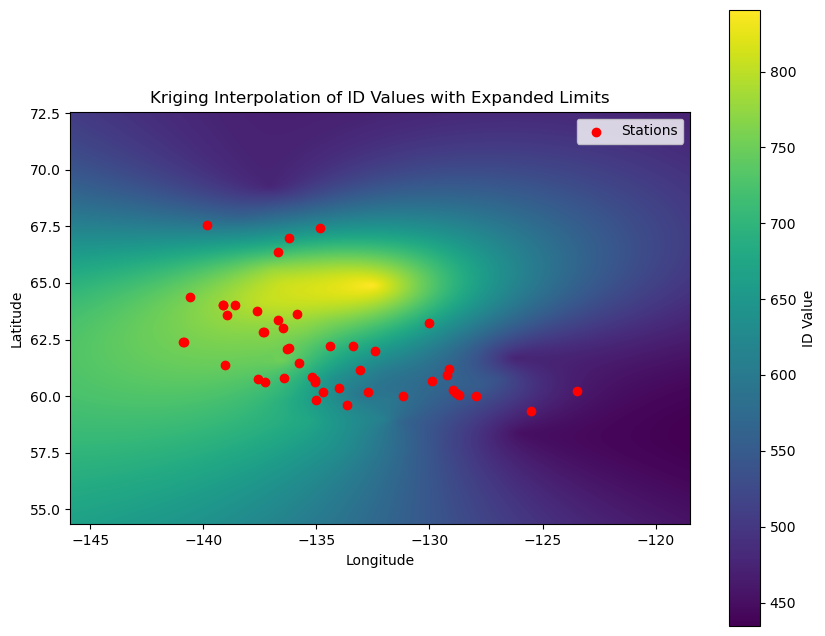

In [6]:
from pydroinformatics.pydroinformatics.src import spatialutils as spu
# Extract coordinates and id values
lons = stations_gdf['longitude'].values
lats = stations_gdf['latitude'].values
values = stations_gdf['elevation'].values
buffer=5

grid_x, grid_y, grid_z = spu.point_to_grid(lons, lats, values, buffer)
# Plot the results with expanded x and y limits
plt.figure(figsize=(10, 8))
plt.imshow(grid_z.T, extent=(stations_gdf['longitude'].min() - buffer, stations_gdf['longitude'].max() + buffer,
                             stations_gdf['latitude'].min() - buffer, stations_gdf['latitude'].max() + buffer),
           origin='lower', cmap='viridis')

plt.colorbar(label='ID Value')
plt.scatter(stations_gdf['longitude'], stations_gdf['latitude'], c='red', label='Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Kriging Interpolation of ID Values with Expanded Limits')
plt.show()


Next, we grab basin boundaries from AquaCache. The basins, alongside the met stations, are plotted below.

<Axes: >

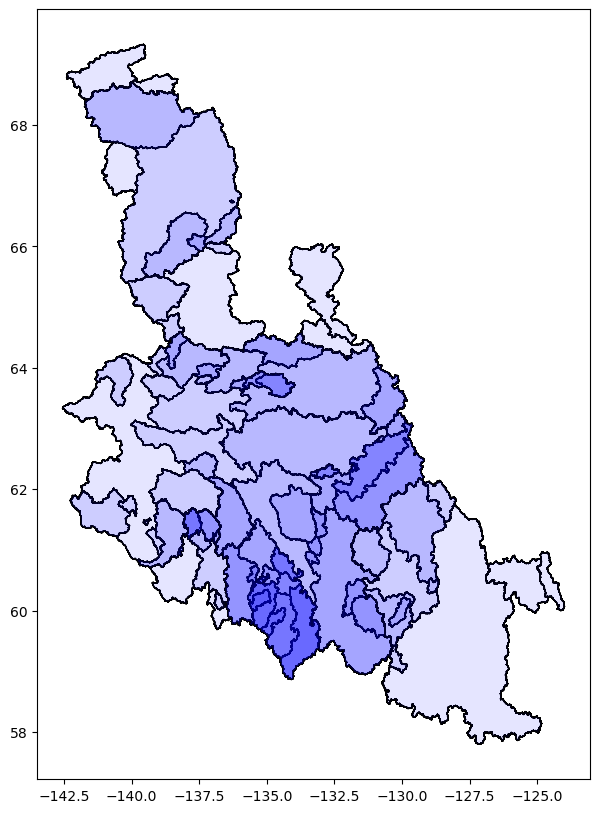

In [7]:


# Load database configuration from .Renviron
sys.path.append(str(Path.home() / "Documents" / "github" / "YGwater" / "dev"))
from pyquacache.defs.config import db_url_dev as db_url



# Create a database engine
engine = create_engine(db_url)

basins = {}
res = []
polys = []
# Test the connection by listing tables
with engine.connect() as connection:
    geom_results = connection.execute(text("SELECT ST_AsText(geom) as geom FROM vectors WHERE layer_name = 'Drainage basins';"))
    results = connection.execute(text("SELECT * FROM vectors WHERE layer_name = 'Drainage basins';"))
    
    for geom_row, row in zip(geom_results, results):
        polys.append(wkt.loads(geom_row)[0])
        res.append(row)
basins = gpd.GeoDataFrame(res, geometry=polys, crs="epsg:4269")
basins.set_index("feature_name", inplace=True)

ax = basins.plot(edgecolor="black", facecolor="none", figsize=(10, 10))
basins.plot(ax=ax, marker='o', color='blue', alpha=0.1, edgecolor="black", markersize=25)


Here, we define a function to sample the continuous gridded results via basin boundaries. The results for elevation, from the OK earlier, are plotted for basin boundaries.

In [8]:
from sqlalchemy import create_engine, text

# Create a database engine
engine = create_engine(db_url)

gdf = {}
res = []
polys = []


stations = basins.index.to_list()

def list_to_sql_string(lst):
    return ", ".join([f"'{item}'" for item in lst])


# Combine the queries into a single SQL statement using JOINs
query = f"""
SELECT 
    t.timeseries_id, t.parameter_id, t.location, p.param_name
FROM 
    timeseries t
JOIN 
    parameters p ON t.parameter_id = p.parameter_id
WHERE 
    t.location IN ({list_to_sql_string(stations)});
"""

with engine.connect() as connection:
    res = connection.execute(text(query))

# Fetch the results into a DataFrame
timeseries_df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
timeseries_df.set_index(timeseries_df.columns[0], inplace=True)
parameter_ids = timeseries_df["parameter_id"]
timeseries_ids = timeseries_df.index.tolist()

with engine.connect() as connection:
    res = connection.execute(text(f"SELECT date, timeseries_id, value FROM measurements_calculated_daily WHERE timeseries_id IN ({list_to_sql_string(timeseries_ids)});"))


df = pd.DataFrame(data=res.fetchall(), columns=res.keys())
df.set_index(df.columns[0], inplace=True)
df.index = pd.to_datetime(df.index)
df["value"] = df["value"].astype(float)

# Group the DataFrame by 'timeseries_id' and pivot to create columns for each timeseries_id
df_grouped = df.pivot_table(index=df.index, columns='timeseries_id', values='value')

# Rename the columns to include 'timeseries_' prefix for clarity
#df_grouped.columns = [f"timeseries_{col}" for col in df_grouped.columns]


# Set the columns as a MultiIndex with 'param_name' and 'location'
df_grouped.columns = pd.MultiIndex.from_tuples(
    [(timeseries_df.loc[col, 'param_name'], timeseries_df.loc[col, 'location']) for col in df_grouped.columns],
    names=['param_name', 'location']
)
# Reset the index to make the DataFrame easier to work with



C:\Users\esniede\AppData\Local\Temp\ipykernel_9276\2855568724.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  basins = basins.assign(area=basins.geometry.area).sort_values(by="area", ascending=False)


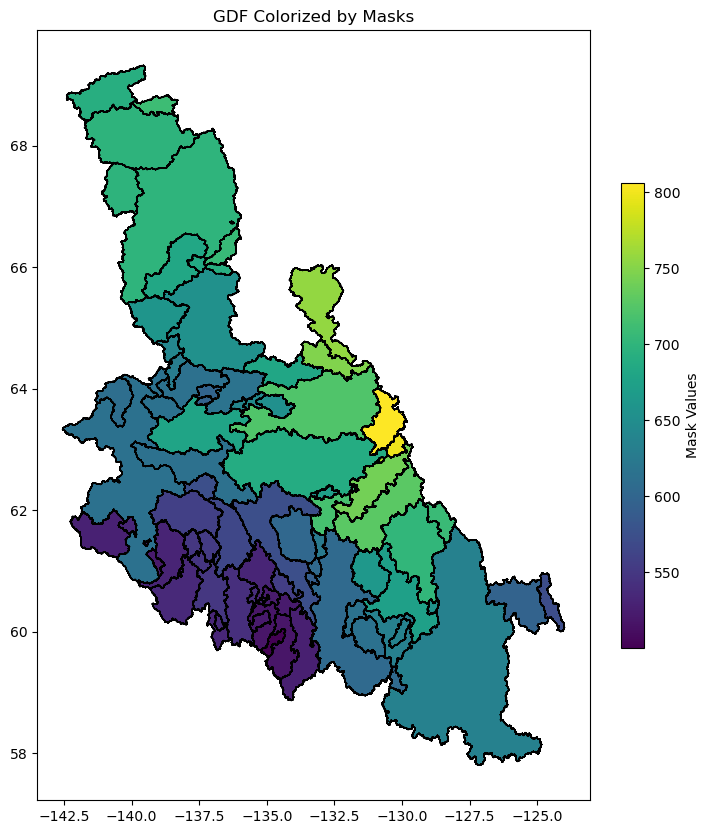

In [9]:
import matplotlib as mpl
from rasterio.transform import from_bounds


grid_x, grid_y, grid_z = spu.point_to_grid(lons, lats, values)
masks = spu.aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf=basins)

# Plot the GeoDataFrame with color based on the masks
fig, ax = plt.subplots(figsize=(10, 10))
basins = basins.assign(area=basins.geometry.area).sort_values(by="area", ascending=False)
# Normalize the mask values for the color map
norm = mpl.colors.Normalize(vmin=min(masks.values()), vmax=max(masks.values()))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

# Plot the GeoDataFrame with color based on the masks
basins.plot(ax=ax, color=[plt.cm.viridis(norm(masks[idx])) for idx in basins.index], edgecolor="black")

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label("Mask Values")

plt.title("GDF Colorized by Masks")
plt.show()


The cell below grabs two variables, drought code and date (as day of year) for freeze and snowfree dataframes. Results are agrigated into a single multi-indexed [year,(basin,param)] dataframe.

In [10]:

years = np.unique(np.concatenate([freeze["freeze_date"].dt.year, snowfree["snowfree_date"].dt.year]))
years = years[~np.isnan(years)]

df = pd.DataFrame(index=years, columns=pd.MultiIndex.from_product([basins.index, ["freeze_doy", "freeze_dc", "snowfree_doy", "snowfree_dc"]]))

datasets = {"freeze": freeze, "snowfree": snowfree}
params = ["dc", "doy"]

# for freeze and thaw df
for key in datasets:
    ds = datasets[key]

    # for each year
    for year in years:

        # for each param (DAY OF YEAR [DOY] and DROUGHT DODE [DC])
        for param in params:
            
            # subset  correct date and non-null
            idx = (ds[f"{key}_date"].dt.year == year) & ds[f"{key}_dc"].notnull()
            

            # get the correct param
            if param == "dc":
                values = ds.loc[idx, f"{key}_dc"].astype(float).values
            elif param == "doy":
                values = ds.loc[idx, f"{key}_date"].dt.dayofyear.astype(float).values
            else:
                raise ValueError("Invalid parameter. Must be either 'dc' or 'doy'.")
            

            # if valid data, get basin avgs
            if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
                lats = ds.loc[idx, "geometry"].y.values
                lons = ds.loc[idx, "geometry"].x.values

                grid_x, grid_y, grid_z = spu.point_to_grid(lons, lats, values)
                basin_avgs = spu.aggregate_gridded_results_by_poly(grid_x, grid_y, grid_z, gdf=basins)
                
                for basin in basins.index:
                    df.loc[year, (basin, f"{key}_{param}")] = basin_avgs[basin]
            
            # 
            elif (len(values) == 1) | (values.var() == 0):
                for basin in basins.index:
                    df.loc[year, (basin, f"{key}_{param}")] = values[0]

            else: 
            # if no values, nan
                for basin in basins.index:
                 df.loc[year, (basin, f"{key}_{param}")] = np.nan


C:\Users\esniede\AppData\Local\Temp\ipykernel_9276\3209362632.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\esniede\AppData\Local\Temp\ipykernel_9276\3209362632.py:44: RuntimeWarning: Degrees of freedom <= 0 for slice
  elif (len(values) == 1) | (values.var() == 0):
C:\Users\esniede\AppData\Local\Temp\ipykernel_9276\3209362632.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  if (values.var() != 0) & (len(values) != 1) & (len(values) != 0):
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwat

Next, we read theannual peak flow/stage and SWE results for select monitoring locaitons

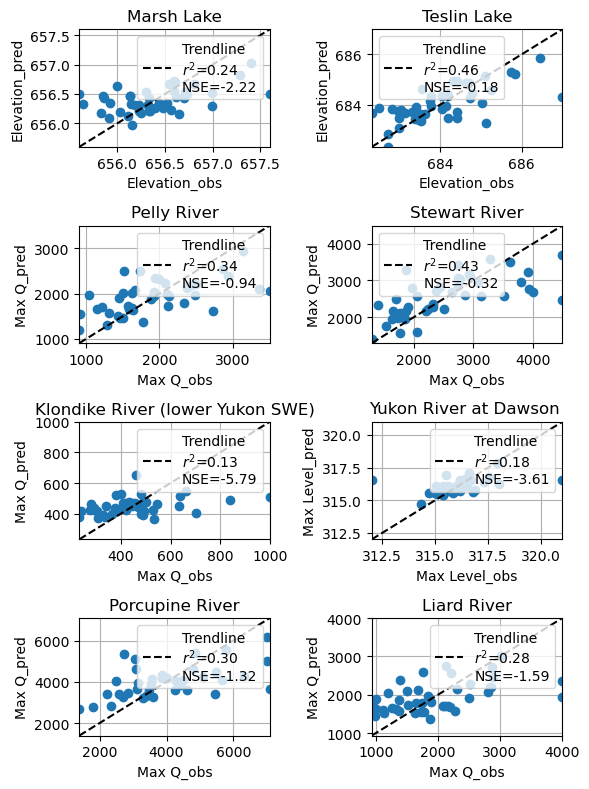

In [11]:
from scipy.stats import linregress
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


annual_hydro = pd.read_excel(".data/annual_peaks.xlsx", header=[0, 1], index_col=0)
annual_hydro.index = annual_hydro.index.astype(int)


# last 4 station matches are a bit uncertain (except yukon @ dawson)..
rename_locations = {"Marsh Lake": "09AB004", "Teslin Lake": "09AE002", "Pelly River": "09BC001", "Stewart River": "09DD003", "Klondike River (lower Yukon SWE)": "09EA003", "Yukon River at Dawson ": "09EB001","Porcupine River": "09FD002", "Liard River": "10AA001"}
for name, code in rename_locations.items():
    annual_hydro.rename(columns={name: code}, level=0, inplace=True)

rename_locations_inv = {v: k for k, v in rename_locations.items()}


# Plot time series for all columns containing "Max Q" or "elevation"
cols = [col for col in annual_hydro.columns if ("Max Q" in col) or ("Elevation" in col) or ("Max Level" in col)]

nrows=4
fig, axs = plt.subplots(nrows=nrows, ncols=int(len(cols)/nrows), figsize=(6, 8), sharex=False)
calc_nse = lambda x, y: 1 - (np.sum((x - y) ** 2) / np.sum((y - np.mean(y)) ** 2))
scores = []

for col in cols:
    ax = axs.flatten()[list(cols).index(col)]

    y = annual_hydro.loc[:,col].values
    x = annual_hydro.loc[:,(col[0], "April SWE%")].values

    # Remove NaNs from x and y for regression
    mask = ~np.isnan(x) & ~np.isnan(y) & (y != 0)
    x = x[mask]
    y = y[mask]
    # Calculate the linear regression

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    y_linear = slope * x + intercept

    # Calculate NSE
    nse = calc_nse(y, y_linear)
    scores.append(nse)
    # Plot the trendline
    y_linear = slope * x + intercept


    ax.plot(y, y_linear,'o')

    ax.set_xlim(min(y.min(), y_linear.min()), max(y.max(), y_linear.max()))
    ax.set_ylim(min(y.min(), y_linear.min()), max(y.max(), y_linear.max()))

    #ax.plot([x.min(), x.max()], [y.min(), y.max()], color='black', linestyle='--', label=f'Trendline\n$r^2$={r_value**2:.2f}\nNSE={nse:.2f}')
    ax.plot( [ax.get_ylim()[0], ax.get_ylim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], color='black', linestyle='--', label=f'Trendline\n$r^2$={r_value**2:.2f}\nNSE={nse:.2f}')
    # Add legend
    ax.legend()
    ax.set_xlabel(f"{col[1]}_obs")
    ax.set_ylabel(f"{col[1]}_pred")
    ax.set_title(f"{rename_locations_inv[col[0]]}")
    ax.grid(True)



fig.tight_layout()



In [12]:
stations_multiindex = annual_hydro.columns.levels[0]
print(len(list(stations_multiindex)))

8


Finally, we merge both dataframes (drought code data and anual hydro data) into a single dataframe. We collapse the station index, in favour of one-hot-encoded station informaiton. This allows us to use the data from all stations for model training, while providing the model with necessary information to distinquish between basins. Currently, stage and discharge are merged into a single column, then normalized. Ultimately, both stage and discharge should be used as independant variables and normalization should be applied on a staiton basis (e.g., prior to collapsing/stacking). TODO.

In [13]:
#print(annual_hydro.head())
print(df.head())

feature_name     09EB001                                          09CD001  \
              freeze_doy   freeze_dc snowfree_doy snowfree_dc  freeze_doy   
2002.0         286.41225  437.305656          NaN         NaN  284.793995   
2003.0        297.069086  528.896552   125.950919  184.751366  296.390086   
2004.0        301.030122  488.903226   128.517241  122.896552  300.385532   
2005.0        278.022348  437.170124   125.833333  135.859852  275.566001   
2006.0        292.484848       477.0   132.599608  118.787879  292.484848   

feature_name                                          10BE001              \
               freeze_dc snowfree_doy snowfree_dc  freeze_doy   freeze_dc   
2002.0        436.417831          NaN         NaN  279.552555  414.755716   
2003.0        528.896552    126.44289  181.580093  293.992831  528.896552   
2004.0        488.903226   128.517241  122.896552  298.001729  488.903226   
2005.0        432.787057   125.833333  122.635734  275.017323  415.483794  

In [14]:
station_cols

NameError: name 'station_cols' is not defined

c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\pandas\core\dtypes\astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


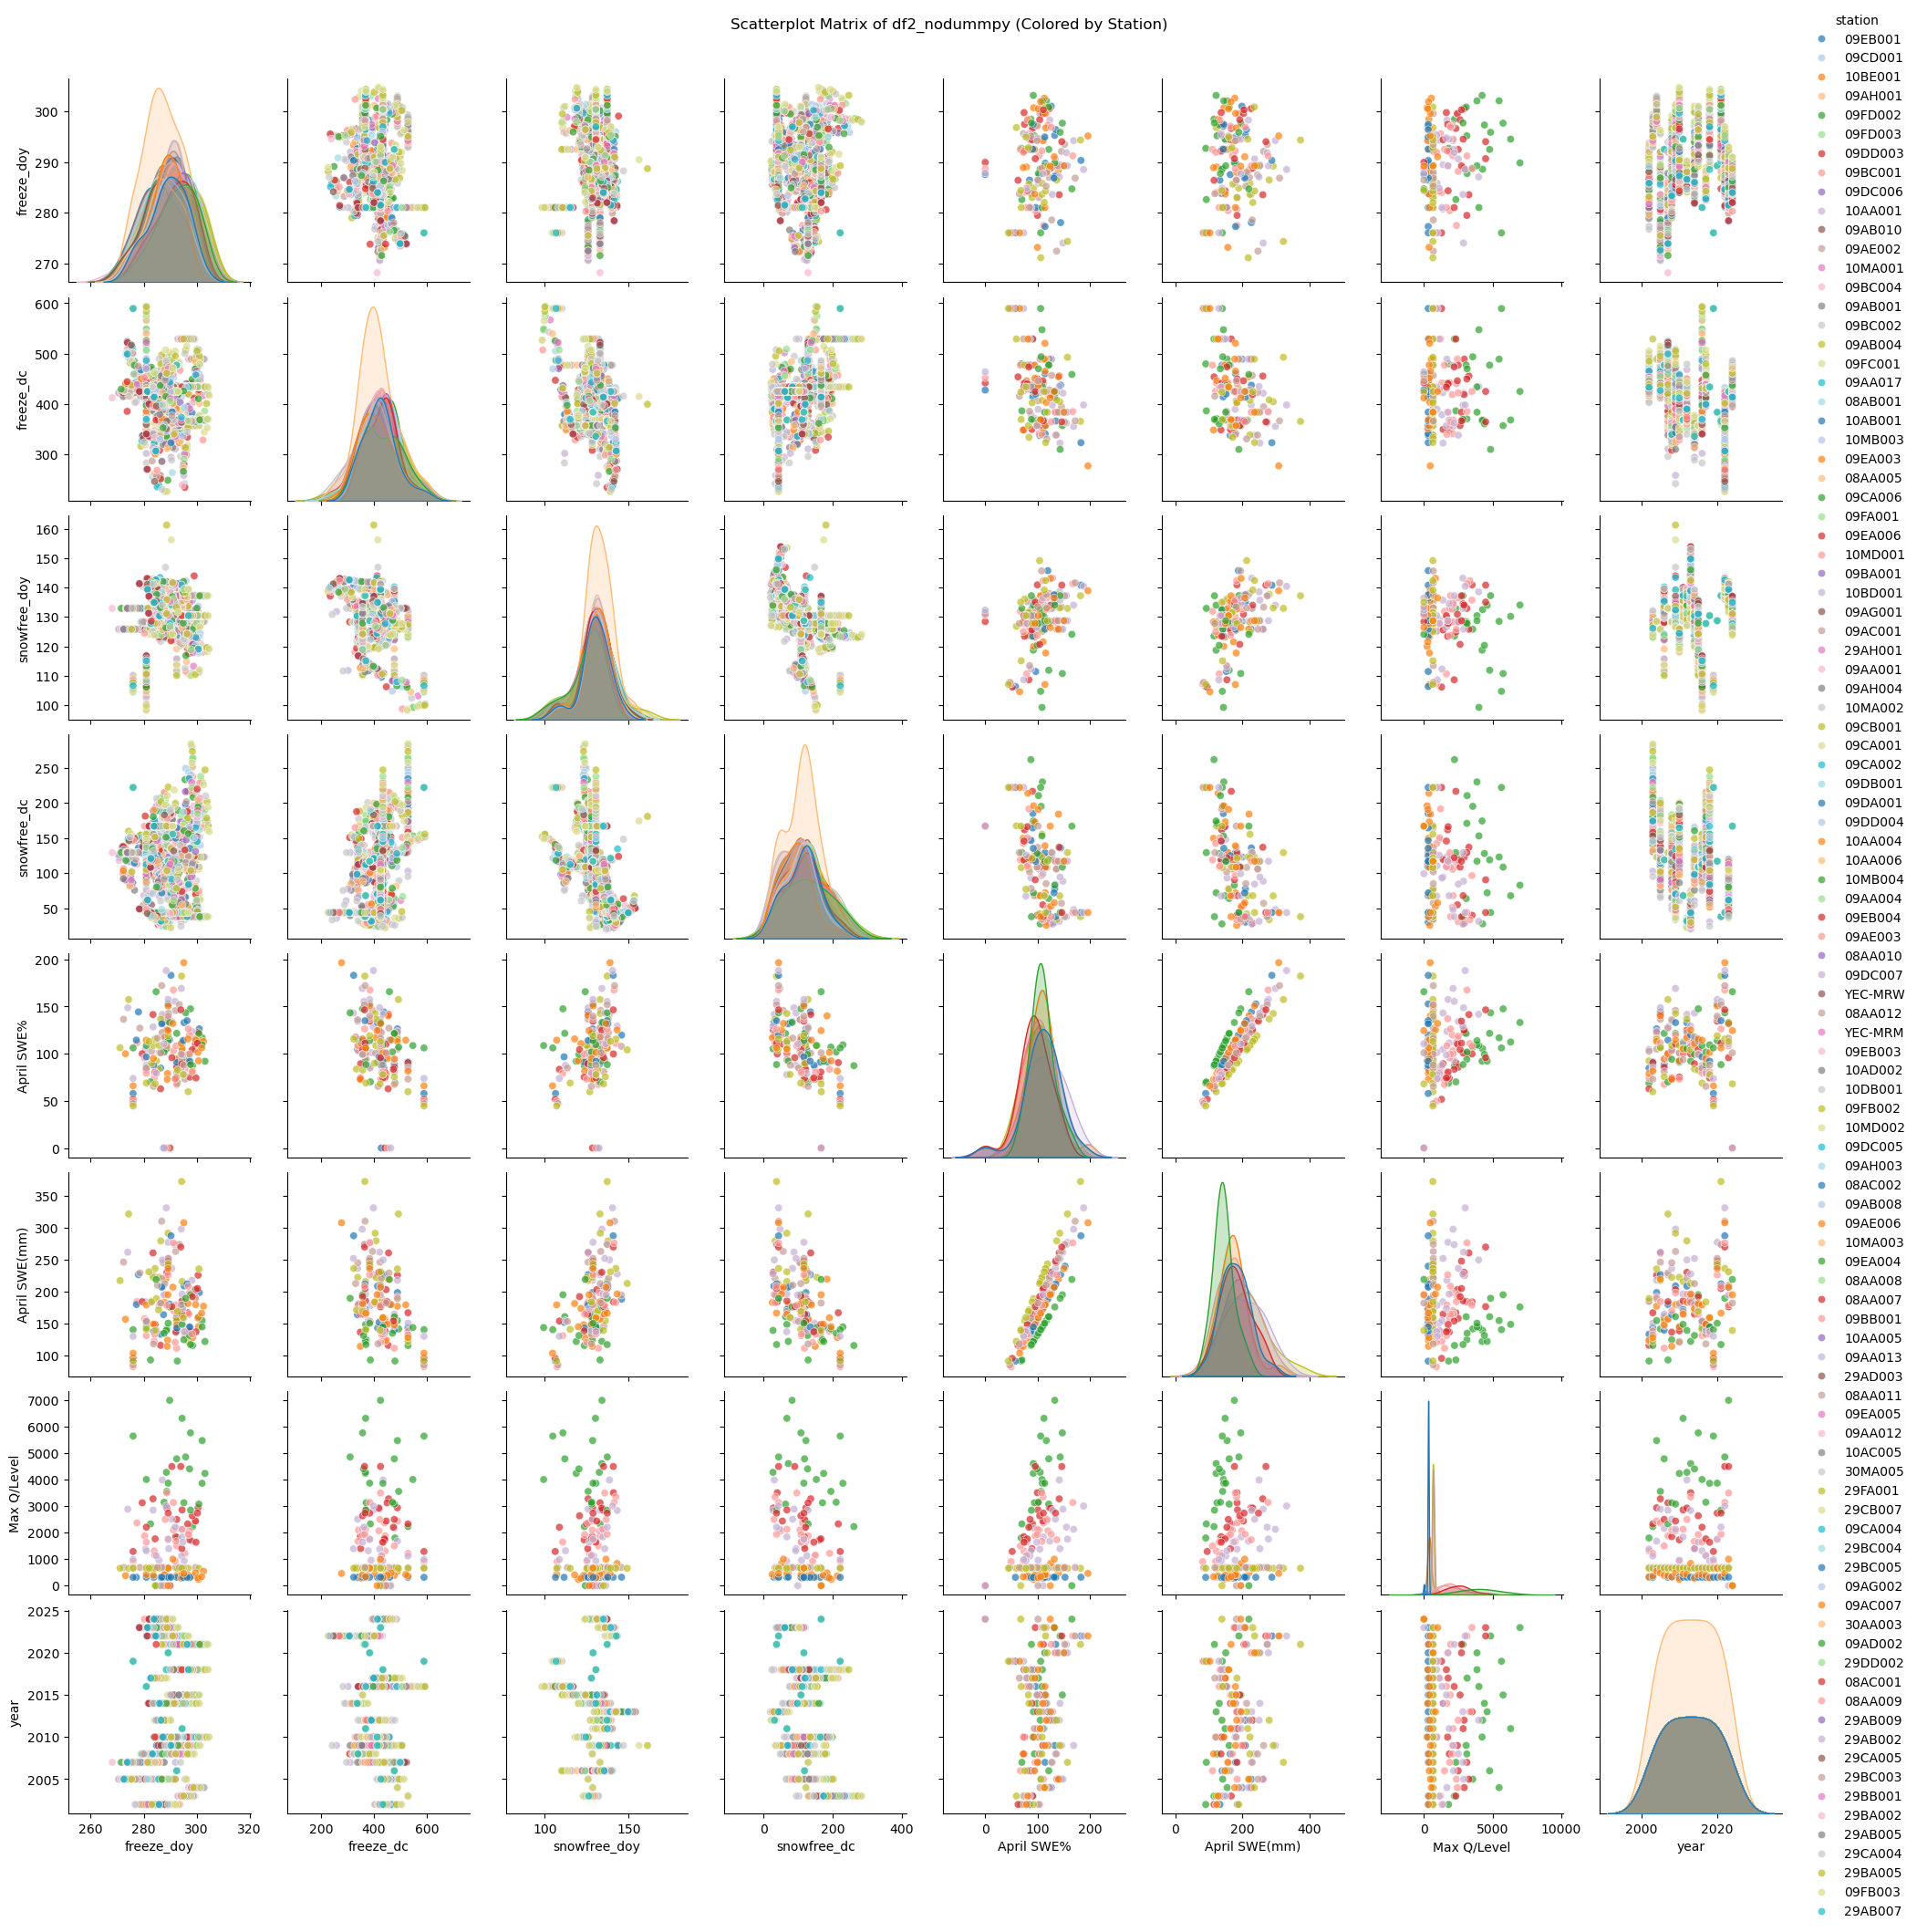

In [ ]:
# Ensure both dataframes have the same index type
df.index = df.index.astype(int)
annual_hydro.index = annual_hydro.index.astype(int)

# Merge the dataframes on their indices
merged_df = pd.merge(df, annual_hydro, left_index=True, right_index=True, how='inner')

# Convert object columns to float where possible
for col in merged_df.columns:
    if merged_df[col].dtype == 'object':
        try:
            merged_df[col] = merged_df[col].astype(float)
        except ValueError:
            pass

data_baseline = merged_df.stack(level=0, future_stack=True)
data_baseline = data_baseline.reset_index(level=1).rename(columns={"level_1": "station"})
data_baseline = pd.get_dummies(data_baseline, columns=["station"], drop_first=True)

# merge these into a single column
data_baseline["Max Q/Level"] = data_baseline[["Max Q", "Max Level", "Elevation"]].apply(lambda x: x.dropna().values[0] if not x.dropna().empty else np.nan, axis=1)
data_baseline.drop(columns=["Max Q", "Max Level", "Elevation"], inplace=True)

station_cols = [col for col in data_baseline.columns if col.startswith("station_")]
cols_to_drop = [col for col in station_cols if data_baseline[col].sum() == 0]
data_baseline = data_baseline.drop(columns=cols_to_drop)
data_baseline

data_n1h = data_baseline.copy()
station_cols = [col for col in data_n1h.columns if col.startswith("station_")]
data_n1h["station"] = data_n1h[station_cols].idxmax(axis=1).str.replace("station_", "")
data_n1h.drop(columns=station_cols, inplace=True)
# Reindex transposed_df2 to ensure a unique integer index
data_n1h["year"] = data_n1h.index
data_n1h.reset_index(drop=True, inplace=True)
# Colour by station column
import seaborn as sns
sns.pairplot(data_n1h, hue="station", diag_kind="kde", palette="tab20", plot_kws={"alpha": 0.7})
plt.suptitle("Scatterplot Matrix of df2_nodummpy (Colored by Station)", y=1.02)
plt.show()

# after plotting, drop the station column
#data_n1h = data_n1h.drop(columns=["station"])



In [ ]:
data_n1h.head()

,freeze_doy,freeze_dc,snowfree_doy,snowfree_dc,April SWE%,April SWE(mm),Max Q/Level,station,year
0,286.412250,437.305656,NaN,NaN,84.763694,133.079,315.356,09EB001,2002
1,284.793995,436.417831,NaN,NaN,NaN,NaN,NaN,09CD001,2002
2,279.552555,414.755716,NaN,NaN,NaN,NaN,NaN,10BE001,2002
3,284.554521,432.875989,NaN,NaN,NaN,NaN,NaN,09AH001,2002
4,292.703130,479.459658,NaN,NaN,68.849357,90.950,1800.000,09FD002,2002


Lastly, we train two models. A multi-variate linear regression model and a random forest model. Peak annual values, and freeze-up data are used to calculate snowfree variables.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score





def train_model_suite(X, y, labels):
    ret = {}


# Split the data into training and testing sets
    idx = np.arange(len(X))
    X_train, X_test, y_train, y_test, idx_train, idx_test= train_test_split(X, y, idx, test_size=0.5, random_state=42)

    labels_train = labels[idx_train]
    labels_test = labels[idx_test]

    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Initialize the scaler
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both train and test sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Apply z-normalization to the target variable (y) as well
    y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()


    # Initialize and train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_linear = model.predict(X_test)

    # Initialize and train the random forest model
    model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_rf = model.predict(X_test)

    # Initialize and train the neural network model
    # Define hyperparameter grid for MLPRegressor
    # Use the best hyperparameters found in previous grid search
    # Hyperparameter grid for MLPRegressor (for hyperparameter optimization)
    # Add low complexity options for MLPRegressor
    param_grid = {
        'hidden_layer_sizes': [(2,), (4,), (8,), (16,), (32,), (64,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'lbfgs'],
        'max_iter': [1000, 5000],
        'random_state': [42],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'adaptive'],
    }

    mlp = MLPRegressor()
    grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    nn_model = grid_search.best_estimator_
    nn_model.fit(X_train, y_train)
    print("Best NN params:", grid_search.best_params_)

    # Make predictions on the test set
    y_pred_nn = nn_model.predict(X_test)
    y_pred_linear_train = model.predict(X_train)
    y_pred_rf_train = model.predict(X_train)
    y_pred_nn_train = nn_model.predict(X_train)

    # Inverse transform predictions to original scale as normal arrays
    y_pred_linear = scaler.inverse_transform(np.array(y_pred_linear).reshape(-1, 1)).flatten()
    y_pred_rf = scaler.inverse_transform(np.array(y_pred_rf).reshape(-1, 1)).flatten()
    y_pred_nn = scaler.inverse_transform(np.array(y_pred_nn).reshape(-1, 1)).flatten()
    y_pred_linear_train = scaler.inverse_transform(np.array(y_pred_linear_train).reshape(-1, 1)).flatten()
    y_pred_rf_train = scaler.inverse_transform(np.array(y_pred_rf_train).reshape(-1, 1)).flatten()
    y_pred_nn_train = scaler.inverse_transform(np.array(y_pred_nn_train).reshape(-1, 1)).flatten()

    y_train = scaler.inverse_transform(np.array(y_train).reshape(-1, 1)).flatten()
    y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).flatten()

    for key in ["y_hat", "nse", "r2"]:
        ret[key] = {}

    for key in ["linear", "rf", "nn"]:
        ret["y_hat"][key] = {}
        ret["nse"][key] = {}
        ret["r2"][key] = {}
        
    for key in ["X", "y"]:
        ret[key] = {}
    
    ret["y_hat"]["linear"]["test"] = y_pred_linear
    ret["y_hat"]["rf"]["test"] = y_pred_rf
    ret["y_hat"]["nn"]["test"] = y_pred_nn
    ret["y_hat"]["linear"]["train"] = y_pred_linear_train
    ret["y_hat"]["rf"]["train"] = y_pred_rf_train
    ret["y_hat"]["nn"]["train"] = y_pred_nn_train

    ret["X"]["train"] = X_train
    ret["X"]["test"] = X_test
    ret["y"]["train"] = y_train
    ret["y"]["test"] = y_test

    ret["nse"]["linear"]["test"] = calc_nse(y_test, y_pred_linear)
    ret["nse"]["rf"]["test"] = calc_nse(y_test, y_pred_rf)
    ret["nse"]["nn"]["test"] = calc_nse(y_test, y_pred_nn)

    ret["r2"]["linear"]["test"] = r2_score(y_test, y_pred_linear)
    ret["r2"]["rf"]["test"] = r2_score(y_test, y_pred_rf)
    ret["r2"]["nn"]["test"] = r2_score(y_test, y_pred_nn)
    
    ret["labels"] = dict()
    ret["labels"]["train"] = labels_train
    ret["labels"]["test"] = labels_test
    return ret

labels = data_n1h["station"]


df2_cleaned = data_n1h.drop(columns="station", inplace=False).dropna()
X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
#X = df2_cleaned[["April SWE%"]]
y = df2_cleaned["Max Q/Level"]
results_n1h = train_model_suite(X, y, labels)

df2_cleaned = data_baseline.dropna()
X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
#X = df2_cleaned[["April SWE%"]]
y = df2_cleaned["Max Q/Level"]
results_baseline = train_model_suite(X, y, labels)

c:\Users\esniede\AppData\Local\miniconda3\envs\ygwater\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best NN params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}
Best NN params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42, 'solver': 'adam'}


In [ ]:
results_baseline["y"]["train"].shape

(79,)

In [ ]:
data_baseline.isna().sum()

freeze_doy          103
freeze_dc           103
snowfree_doy        104
snowfree_dc         104
April SWE%         2116
                   ... 
station_30AA003       0
station_30MA005       0
station_YEC-MRM       0
station_YEC-MRW       0
Max Q/Level        2123
Length: 106, dtype: int64

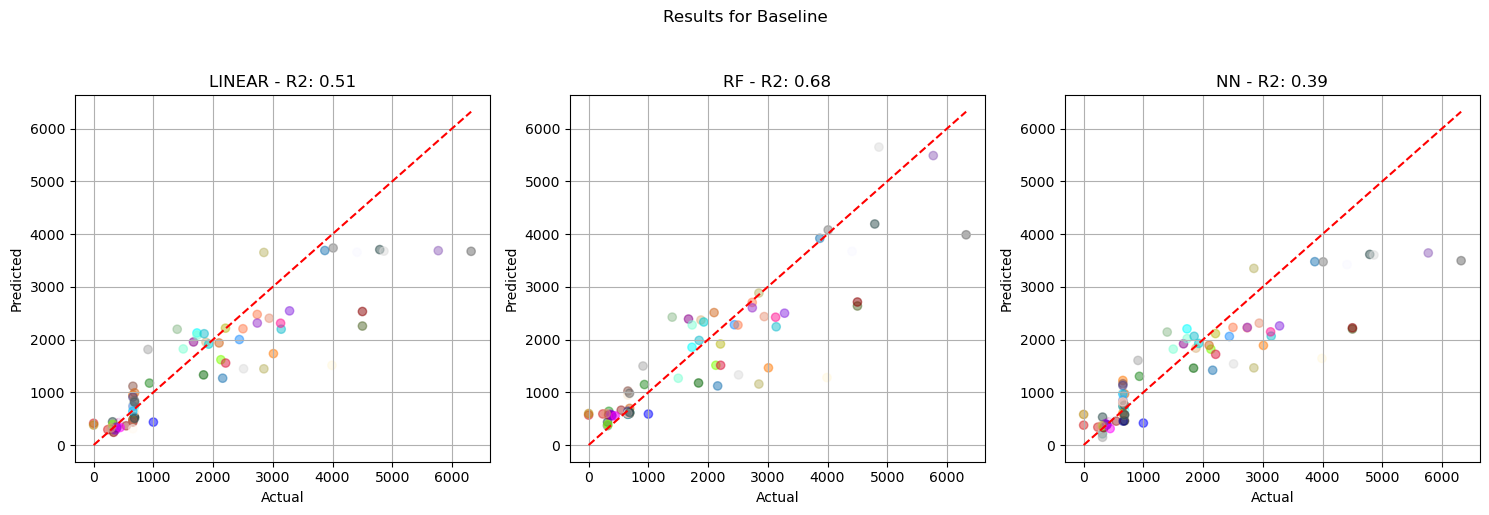

61


In [ ]:
def plot_results_scatter(res, div="test", title="Results"):
    """
    Plot scatter plots of predicted vs actual values for each model in the results dictionary.
    
    Parameters:
    res (dict): Dictionary containing model results.
    div (str): Division of data to plot ('train' or 'test').
    """
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    import matplotlib.colors as mcolors
    # Use named colors for stations, cycling through available colors if needed
    named_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
    unique_labels = res["labels"][div].unique()
    color_dict = {label: named_colors[i % len(named_colors)] for i, label in enumerate(unique_labels)}
    for i, model in enumerate(res["y_hat"].keys()):
        ax = axs[i]
        y_true = res["y"][div]
        y_pred = res["y_hat"][model][div]
        labels = res["labels"][div].to_list()
        scatter = ax.scatter(y_true, y_pred, alpha=0.5, c=[color_dict[label] for label in labels])
        ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"{model.upper()} - R2: {res['nse'][model][div]:.2f}")
        ax.grid(True)
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.subplots_adjust(top=0.85)
    plt.show()
    print(len(unique_labels))
#plot_results_scatter(results_n1h, div="test", title="Results for N1H")
plot_results_scatter(results_baseline, div="test", title="Results for Baseline")

In [ ]:
x

array([ 88.40604408,  92.33696887,  69.22290389,  80.91342877,
        81.66893888, 124.97159736, 100.87480118,  83.37877755,
       108.3049307 , 106.65757782, 119.46148603, 117.37105203,
       167.7402863 ,  95.2510793 , 120.96114519,  88.04249034,
        80.25448762,  99.76709839,  91.33151556,  82.89025222,
        93.21177005, 104.55010225,  85.42944785, 123.66507612,
       148.72756192,  93.4730743 , 128.4935242 , 134.25925926,
       169.23994547, 101.27243808, 111.37809589, 141.80299932,
       129.29447853, 143.12088162,  98.64235401,  87.67325608,
        79.10702113,  77.84026358,  73.75028403, 157.53805953,
       155.44762554, 188.22994774, 110.55441945])

c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


c:\USERS\ESNIEDE\APPDATA\LOCAL\MINICONDA3\ENVS\YGWATER\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best NN params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (8,), 'max_iter': 5000, 'random_state': 42, 'solver': 'adam'}


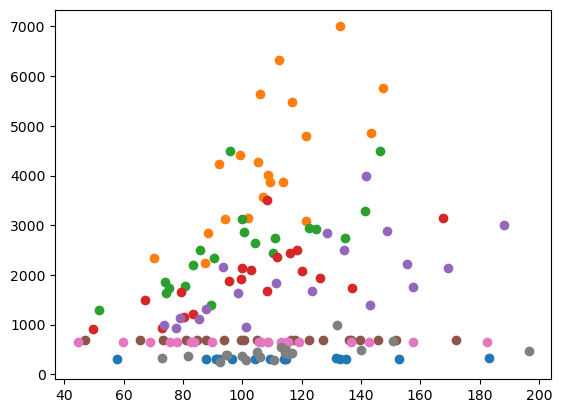

In [ ]:

for station in stations:
    station_data = data_n1h[data_n1h["station"] == station]
    station_data = station_data.drop(columns=["station"], inplace=False)
    df2_cleaned = station_data.dropna()
    X = df2_cleaned.drop(columns=["snowfree_dc", "snowfree_doy","Max Q/Level"])
    X = df2_cleaned[["April SWE%"]]
    X
    y = df2_cleaned["Max Q/Level"]

    idx = y == 0
    X = X[~idx]
    y = y[~idx]
    
    if len(X) > 0 and len(y) > 0:
        results_n1h_station = train_model_suite(X, y)
        #plot_results_scatter(results_n1h_station, div="test", title=f"Results for {station} - N1H")
        
        plt.plot(X,y,'o')




In [ ]:

print(f"NSE value for Neural Net: {nse_nn}")
print(f"NSE value for Linear Regression: {nse_linear}")
print(f"NSE value for Random Forest: {nse_rf}")

# Plot the 1:1 graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, color='blue', label='Linear Regression')
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.scatter(y_test, y_pred_nn, color='purple', label='Neural Net', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='1:1 Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('1:1 Graph of Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()X_train

array([[-1.57864614,  2.33263142, -2.19875079, ...,  0.        ,
         0.        , -0.41429637],
       [ 0.95451237, -0.99078088, -0.20713903, ...,  0.        ,
         0.        ,  0.75351956],
       [ 1.35664998,  0.10581422, -1.14002725, ...,  0.        ,
         0.        ,  0.4307591 ],
       ...,
       [ 2.06234987,  0.8222153 ,  0.28813416, ...,  0.        ,
         0.        , -0.52541876],
       [-0.89448283, -0.21798129, -0.32779806, ...,  0.        ,
         0.        , -0.71064927],
       [-0.43991651,  0.0861676 , -0.93521781, ...,  0.        ,
         0.        ,  0.46061444]], shape=(31, 104))